In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function
import itertools
#from tensorflow.python.ops import math_ops

%matplotlib inline

In [2]:
#%run ./importWalkingDataConfidence_strongerWts.ipynb
%run ./importWalkingDataConfidence.ipynb
tf.logging.set_verbosity(tf.logging.INFO)

./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {
./dataFix.ipynb:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  {


Dimension of walking test_x  =  (134, 27)
Dimension of walking train_x =  (536, 27)


In [3]:
def get_input_fn(data_x,data_y, LABEL, num_epochs=None, shuffle=True):
  return tf.estimator.inputs.pandas_input_fn(
      x=pd.DataFrame({k: data_x[k].values for k in FEATURESALL_WTS}),
      y = pd.DataFrame(data_y[LABEL].values),
      num_epochs=num_epochs,
      shuffle=shuffle)

In [4]:
embedded_ffp_column = tf.contrib.layers.embedding_column(
    tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64), dimension = 7)
sparse_ffp_column =  tf.contrib.layers.sparse_column_with_integerized_feature("FFPType", 7, combiner=None, dtype=tf.int64)
# Continuous columns- frontKneesAngle	rearKneesAngle	frontAnkle	rearAnkle	frontHipsAngle
bodyZ = tf.feature_column.numeric_column("bodyAngleZ")
frontK = tf.feature_column.numeric_column("frontKneesAngle")
rearK = tf.feature_column.numeric_column("rearKneesAngle")
frontA = tf.feature_column.numeric_column("frontAnkle")
rearA = tf.feature_column.numeric_column("rearAnkle")
frontH = tf.feature_column.numeric_column("frontHipsAngle")
rearH = tf.feature_column.numeric_column("rearHipsAngle")
swingFtHt = tf.feature_column.numeric_column("swingFtHeight")
speed = tf.feature_column.numeric_column("speed")
gaitTime = tf.feature_column.numeric_column("gaitDuration")

feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, embedded_ffp_column]
lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime]
#lin_feature_cols = [sparse_ffp_column]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime, sparse_ffp_column]
#lin_feature_cols = [bodyZ, swingFtHt, speed, gaitTime]
#lin_feature_cols = [bodyZ, frontK, rearK, frontA, rearA, frontH, rearH, swingFtHt, speed, gaitTime, sparse_ffp_column]

In [5]:
LABEL_ID = 2;
LABEL = EMOSCORES[LABEL_ID]
WT_COL = WTS_LABEL[LABEL_ID]

In [6]:
LABEL

'angrier_mu'

In [7]:
# validation_metrics = {
#     "rmse":
#         tf.metrics.root_mean_squared_error(labels = pd.DataFrame(y_test[LABEL].values),predictions=y_predicted)
# }

In [8]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False),
    every_n_steps=50,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=500) #200 500 1000
    #metrics=validation_metrics)

Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


In [9]:
# Build a wide + deep model
#model_dir_name="/DNN/wideAndDeep/wideMotionBodyAngDeepAllStrngWts_ConfidenceSoftplus2Layer10_10UnitsDropout01EarlyStopLR001"
model_dir_name="/DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001"

# regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
#   dnn_feature_columns=feature_cols, dnn_hidden_units=[1000],  model_dir=model_dir_name, weight_column_name = WT_COL,
#     dnn_optimizer = tf.train.AdamOptimizer(
#       learning_rate=0.01), dnn_dropout =0.1, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.softplus)

regressor = tf.contrib.learn.DNNLinearCombinedRegressor(linear_feature_columns = lin_feature_cols,
  dnn_feature_columns=feature_cols, dnn_hidden_units=[100,100],  model_dir=model_dir_name, weight_column_name = WT_COL,
    dnn_optimizer = tf.train.AdamOptimizer(
      learning_rate=0.001), dnn_dropout =0.2, config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1), dnn_activation_fn = tf.nn.elu)

#tf.contrib.layers.xavier_initializer(uniform=True) # this seems more useful for vision stuff where there is lot of fan_in and fan_out

Instructions for updating:
Please set fix_global_step_increment_bug=True and update training steps in your pipeline. See pydoc for details.
INFO:tensorflow:Using config: {'_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_is_chief': True, '_save_checkpoints_steps': None, '_evaluation_master': '', '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001', '_session_config': None, '_save_summary_steps': 100, '_master': '', '_task_type': None, '_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_save_checkpoints_secs': 1, '_tf_random_seed': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001ACF194ED30>, '_num_worker_replicas': 0, '_environment': 'local', '_keep_checkpoint_every_n_hours': 10000}


In [10]:
# Train.
regressor.fit(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=None, shuffle=True),steps=200000, monitors=[validation_monitor]) #2000000

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 2 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:loss = 359.613, step = 2
INFO:tensorflow:Saving checkpoints for 4 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 6 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 8 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 10 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 12 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_Confiden

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-21:58:12
INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-52
INFO:tensorflow:Finished evaluation at 2017-10-18-21:58:13
INFO:tensorflow:Saving dict for global step 52: global_step = 52, loss = 481.114
INFO:tensorflow:Validation (step 51): loss = 481.114, global_step = 52
INFO:tensorflow:Saving checkpoints for 54 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 56 into /DNNNew/DNNAngry/wideAndDeep/an

  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\estimators\head.py", line 1760, in _weight_tensor
    weight_column_name, shape)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\platform\tf_logging.py", line 90, in warning
    _logger.warning(msg, *args, **kwargs)
Message: 'Weights {} has shape {}, expanding to make it 2d.'
Arguments: ('angrier_wt', TensorShape([Dimension(None)]))
--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in 

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-102
INFO:tensorflow:Finished evaluation at 2017-10-18-21:58:50
INFO:tensorflow:Saving dict for global step 102: global_step = 102, loss = 243.021
INFO:tensorflow:Validation (step 101): loss = 243.021, global_step = 102
INFO:tensorflow:Saving checkpoints for 104 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 106 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 108 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 110 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-152
INFO:tensorflow:Finished evaluation at 2017-10-18-21:59:26
INFO:tensorflow:Saving dict for global step 152: global_step = 152, loss = 66.7644
INFO:tensorflow:Validation (step 151): loss = 66.7644, global_step = 152
INFO:tensorflow:Saving checkpoints for 154 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 156 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 158 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 160 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-202
INFO:tensorflow:Finished evaluation at 2017-10-18-22:00:02
INFO:tensorflow:Saving dict for global step 202: global_step = 202, loss = 56.6807
INFO:tensorflow:Validation (step 201): loss = 56.6807, global_step = 202
INFO:tensorflow:loss = 22.6138, step = 202 (145.760 sec)
INFO:tensorflow:Saving checkpoints for 204 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 206 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 208 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 210 into /DNNNew/DNNAngry/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-252
INFO:tensorflow:Finished evaluation at 2017-10-18-22:00:39
INFO:tensorflow:Saving dict for global step 252: global_step = 252, loss = 46.9399
INFO:tensorflow:Validation (step 251): loss = 46.9399, global_step = 252
INFO:tensorflow:Saving checkpoints for 254 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 256 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 258 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 260 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-302
INFO:tensorflow:Finished evaluation at 2017-10-18-22:01:16
INFO:tensorflow:Saving dict for global step 302: global_step = 302, loss = 42.8989
INFO:tensorflow:Validation (step 301): loss = 42.8989, global_step = 302
INFO:tensorflow:Saving checkpoints for 304 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 306 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 308 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 310 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-352
INFO:tensorflow:Finished evaluation at 2017-10-18-22:01:52
INFO:tensorflow:Saving dict for global step 352: global_step = 352, loss = 37.3388
INFO:tensorflow:Validation (step 351): loss = 37.3388, global_step = 352
INFO:tensorflow:Saving checkpoints for 354 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 356 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 358 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 360 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-402
INFO:tensorflow:Finished evaluation at 2017-10-18-22:02:28
INFO:tensorflow:Saving dict for global step 402: global_step = 402, loss = 37.7088
INFO:tensorflow:Validation (step 401): loss = 37.7088, global_step = 402
INFO:tensorflow:loss = 17.8915, step = 402 (145.837 sec)
INFO:tensorflow:Saving checkpoints for 404 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 406 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 408 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 410 into /DNNNew/DNNAngry/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-452
INFO:tensorflow:Finished evaluation at 2017-10-18-22:03:04
INFO:tensorflow:Saving dict for global step 452: global_step = 452, loss = 35.4256
INFO:tensorflow:Validation (step 451): loss = 35.4256, global_step = 452
INFO:tensorflow:Saving checkpoints for 454 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 456 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 458 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 460 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-502
INFO:tensorflow:Finished evaluation at 2017-10-18-22:03:40
INFO:tensorflow:Saving dict for global step 502: global_step = 502, loss = 33.567
INFO:tensorflow:Validation (step 501): loss = 33.567, global_step = 502
INFO:tensorflow:Saving checkpoints for 504 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 506 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 508 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 510 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropou

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-552
INFO:tensorflow:Finished evaluation at 2017-10-18-22:04:16
INFO:tensorflow:Saving dict for global step 552: global_step = 552, loss = 32.0327
INFO:tensorflow:Validation (step 551): loss = 32.0327, global_step = 552
INFO:tensorflow:Saving checkpoints for 554 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 556 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 558 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 560 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-602
INFO:tensorflow:Finished evaluation at 2017-10-18-22:04:51
INFO:tensorflow:Saving dict for global step 602: global_step = 602, loss = 32.4069
INFO:tensorflow:Validation (step 601): loss = 32.4069, global_step = 602
INFO:tensorflow:loss = 14.4274, step = 602 (143.214 sec)
INFO:tensorflow:Saving checkpoints for 604 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 606 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 608 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 610 into /DNNNew/DNNAngry/wideAndDee

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-652
INFO:tensorflow:Finished evaluation at 2017-10-18-22:05:28
INFO:tensorflow:Saving dict for global step 652: global_step = 652, loss = 31.5983
INFO:tensorflow:Validation (step 651): loss = 31.5983, global_step = 652
INFO:tensorflow:Saving checkpoints for 654 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 656 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 658 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 660 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-22:06:03
INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-702
INFO:tensorflow:Finished evaluation at 2017-10-18-22:06:04
INFO:tensorflow:Saving dict for global step 702: global_step = 702, loss = 30.9079
INFO:tensorflow:Validation (step 701): loss = 30.9079, global_step = 702
INFO:tensorflow:Saving checkpoints for 704 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 706 into /DNNNew/DNNAngry/wideAnd

  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\monitored_session.py", line 862, in run
    run_metadata=run_metadata)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\monitored_session.py", line 818, in run
    return self._sess.run(*args, **kwargs)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\training\monitored_session.py", line 980, in run
    run_metadata=run_metadata))
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\monitors.py", line 1198, in after_run
    induce_stop = m.step_end(self._last_step, result)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\monitors.py", line 358, in step_end
    return self.every_n_

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-22:06:40
INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-752
INFO:tensorflow:Finished evaluation at 2017-10-18-22:06:41
INFO:tensorflow:Saving dict for global step 752: global_step = 752, loss = 30.9721
INFO:tensorflow:Validation (step 751): loss = 30.9721, global_step = 752
INFO:tensorflow:Saving checkpoints for 754 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 756 into /DNNNew/DNNAngry/wideAnd

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-802
INFO:tensorflow:Finished evaluation at 2017-10-18-22:07:17
INFO:tensorflow:Saving dict for global step 802: global_step = 802, loss = 29.2845
INFO:tensorflow:Validation (step 801): loss = 29.2845, global_step = 802
INFO:tensorflow:loss = 13.087, step = 802 (146.028 sec)
INFO:tensorflow:Saving checkpoints for 804 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 806 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 808 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 810 into /DNNNew/DNNAngry/wideAndDeep

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-852
INFO:tensorflow:Finished evaluation at 2017-10-18-22:07:53
INFO:tensorflow:Saving dict for global step 852: global_step = 852, loss = 29.4084
INFO:tensorflow:Validation (step 851): loss = 29.4084, global_step = 852
INFO:tensorflow:Saving checkpoints for 854 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 856 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 858 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 860 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-902
INFO:tensorflow:Finished evaluation at 2017-10-18-22:08:31
INFO:tensorflow:Saving dict for global step 902: global_step = 902, loss = 29.1918
INFO:tensorflow:Validation (step 901): loss = 29.1918, global_step = 902
INFO:tensorflow:Saving checkpoints for 904 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 906 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 908 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 910 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-952
INFO:tensorflow:Finished evaluation at 2017-10-18-22:09:07
INFO:tensorflow:Saving dict for global step 952: global_step = 952, loss = 29.3898
INFO:tensorflow:Validation (step 951): loss = 29.3898, global_step = 952
INFO:tensorflow:Saving checkpoints for 954 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 956 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 958 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 960 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDrop

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1002
INFO:tensorflow:Finished evaluation at 2017-10-18-22:09:43
INFO:tensorflow:Saving dict for global step 1002: global_step = 1002, loss = 28.6568
INFO:tensorflow:Validation (step 1001): loss = 28.6568, global_step = 1002
INFO:tensorflow:loss = 13.6167, step = 1002 (145.263 sec)
INFO:tensorflow:Saving checkpoints for 1004 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1006 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1008 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1010 into /DNNNew/DNNAngry/

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1052
INFO:tensorflow:Finished evaluation at 2017-10-18-22:10:18
INFO:tensorflow:Saving dict for global step 1052: global_step = 1052, loss = 28.5298
INFO:tensorflow:Validation (step 1051): loss = 28.5298, global_step = 1052
INFO:tensorflow:Saving checkpoints for 1054 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1056 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1058 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1060 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1102
INFO:tensorflow:Finished evaluation at 2017-10-18-22:10:54
INFO:tensorflow:Saving dict for global step 1102: global_step = 1102, loss = 27.0832
INFO:tensorflow:Validation (step 1101): loss = 27.0832, global_step = 1102
INFO:tensorflow:Saving checkpoints for 1104 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1106 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1108 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1110 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1152
INFO:tensorflow:Finished evaluation at 2017-10-18-22:11:30
INFO:tensorflow:Saving dict for global step 1152: global_step = 1152, loss = 27.6117
INFO:tensorflow:Validation (step 1151): loss = 27.6117, global_step = 1152
INFO:tensorflow:Saving checkpoints for 1154 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1156 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1158 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1160 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1202
INFO:tensorflow:Finished evaluation at 2017-10-18-22:12:06
INFO:tensorflow:Saving dict for global step 1202: global_step = 1202, loss = 28.264
INFO:tensorflow:Validation (step 1201): loss = 28.264, global_step = 1202
INFO:tensorflow:loss = 10.9155, step = 1202 (143.210 sec)
INFO:tensorflow:Saving checkpoints for 1204 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1206 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1208 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1210 into /DNNNew/DNNAngry/wi

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1252
INFO:tensorflow:Finished evaluation at 2017-10-18-22:12:42
INFO:tensorflow:Saving dict for global step 1252: global_step = 1252, loss = 28.8268
INFO:tensorflow:Validation (step 1251): loss = 28.8268, global_step = 1252
INFO:tensorflow:Saving checkpoints for 1254 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1256 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1258 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1260 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Starting evaluation at 2017-10-18-22:13:17
INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1302
INFO:tensorflow:Finished evaluation at 2017-10-18-22:13:17
INFO:tensorflow:Saving dict for global step 1302: global_step = 1302, loss = 27.5513
INFO:tensorflow:Validation (step 1301): loss = 27.5513, global_step = 1302
INFO:tensorflow:Saving checkpoints for 1304 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1306 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1308 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1310 into /DNNNew/DNNAngry

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1352
INFO:tensorflow:Finished evaluation at 2017-10-18-22:13:53
INFO:tensorflow:Saving dict for global step 1352: global_step = 1352, loss = 27.9719
INFO:tensorflow:Validation (step 1351): loss = 27.9719, global_step = 1352
INFO:tensorflow:Saving checkpoints for 1354 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1356 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1358 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1360 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1402
INFO:tensorflow:Finished evaluation at 2017-10-18-22:14:29
INFO:tensorflow:Saving dict for global step 1402: global_step = 1402, loss = 26.7482
INFO:tensorflow:Validation (step 1401): loss = 26.7482, global_step = 1402
INFO:tensorflow:loss = 15.0815, step = 1402 (143.251 sec)
INFO:tensorflow:Saving checkpoints for 1404 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1406 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1408 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1410 into /DNNNew/DNNAngry/

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1452
INFO:tensorflow:Finished evaluation at 2017-10-18-22:15:05
INFO:tensorflow:Saving dict for global step 1452: global_step = 1452, loss = 27.9092
INFO:tensorflow:Validation (step 1451): loss = 27.9092, global_step = 1452
INFO:tensorflow:Saving checkpoints for 1454 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1456 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1458 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1460 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1502
INFO:tensorflow:Finished evaluation at 2017-10-18-22:15:41
INFO:tensorflow:Saving dict for global step 1502: global_step = 1502, loss = 27.6664
INFO:tensorflow:Validation (step 1501): loss = 27.6664, global_step = 1502
INFO:tensorflow:Saving checkpoints for 1504 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1506 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1508 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1510 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Starting evaluation at 2017-10-18-22:16:16
INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1552
INFO:tensorflow:Finished evaluation at 2017-10-18-22:16:17
INFO:tensorflow:Saving dict for global step 1552: global_step = 1552, loss = 27.5392
INFO:tensorflow:Validation (step 1551): loss = 27.5392, global_step = 1552
INFO:tensorflow:Saving checkpoints for 1554 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1556 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1558 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1560 into /DNNNew/DNNAngry

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1602
INFO:tensorflow:Finished evaluation at 2017-10-18-22:16:53
INFO:tensorflow:Saving dict for global step 1602: global_step = 1602, loss = 27.1006
INFO:tensorflow:Validation (step 1601): loss = 27.1006, global_step = 1602
INFO:tensorflow:loss = 14.393, step = 1602 (143.514 sec)
INFO:tensorflow:Saving checkpoints for 1604 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1606 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1608 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1610 into /DNNNew/DNNAngry/w

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1652
INFO:tensorflow:Finished evaluation at 2017-10-18-22:17:28
INFO:tensorflow:Saving dict for global step 1652: global_step = 1652, loss = 27.5159
INFO:tensorflow:Validation (step 1651): loss = 27.5159, global_step = 1652
INFO:tensorflow:Saving checkpoints for 1654 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1656 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1658 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1660 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1702
INFO:tensorflow:Finished evaluation at 2017-10-18-22:18:04
INFO:tensorflow:Saving dict for global step 1702: global_step = 1702, loss = 26.4771
INFO:tensorflow:Validation (step 1701): loss = 26.4771, global_step = 1702
INFO:tensorflow:Saving checkpoints for 1704 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1706 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1708 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1710 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1752
INFO:tensorflow:Finished evaluation at 2017-10-18-22:18:40
INFO:tensorflow:Saving dict for global step 1752: global_step = 1752, loss = 27.1314
INFO:tensorflow:Validation (step 1751): loss = 27.1314, global_step = 1752
INFO:tensorflow:Saving checkpoints for 1754 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1756 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1758 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1760 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1802
INFO:tensorflow:Finished evaluation at 2017-10-18-22:19:17
INFO:tensorflow:Saving dict for global step 1802: global_step = 1802, loss = 26.9646
INFO:tensorflow:Validation (step 1801): loss = 26.9646, global_step = 1802
INFO:tensorflow:loss = 12.6812, step = 1802 (144.175 sec)
INFO:tensorflow:Saving checkpoints for 1804 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1806 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1808 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1810 into /DNNNew/DNNAngry/

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1852
INFO:tensorflow:Finished evaluation at 2017-10-18-22:19:53
INFO:tensorflow:Saving dict for global step 1852: global_step = 1852, loss = 28.155
INFO:tensorflow:Validation (step 1851): loss = 28.155, global_step = 1852
INFO:tensorflow:Saving checkpoints for 1854 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1856 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1858 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1860 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100Un

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1902
INFO:tensorflow:Finished evaluation at 2017-10-18-22:20:30
INFO:tensorflow:Saving dict for global step 1902: global_step = 1902, loss = 27.0125
INFO:tensorflow:Validation (step 1901): loss = 27.0125, global_step = 1902
INFO:tensorflow:Saving checkpoints for 1904 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1906 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1908 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1910 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-22:21:06
INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-1952
INFO:tensorflow:Finished evaluation at 2017-10-18-22:21:07
INFO:tensorflow:Saving dict for global step 1952: global_step = 1952, loss = 26.9202
INFO:tensorflow:Validation (step 1951): loss = 26.9202, global_step = 1952
INFO:tensorflow:Saving checkpoints for 1954 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 1956 into /DNNNew/DNNAngry/

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2002
INFO:tensorflow:Finished evaluation at 2017-10-18-22:21:43
INFO:tensorflow:Saving dict for global step 2002: global_step = 2002, loss = 26.7261
INFO:tensorflow:Validation (step 2001): loss = 26.7261, global_step = 2002
INFO:tensorflow:loss = 11.4132, step = 2002 (146.432 sec)
INFO:tensorflow:Saving checkpoints for 2004 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2006 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2008 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2010 into /DNNNew/DNNAngry/

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2052
INFO:tensorflow:Finished evaluation at 2017-10-18-22:22:20
INFO:tensorflow:Saving dict for global step 2052: global_step = 2052, loss = 27.9232
INFO:tensorflow:Validation (step 2051): loss = 27.9232, global_step = 2052
INFO:tensorflow:Saving checkpoints for 2054 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2056 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2058 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2060 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2102
INFO:tensorflow:Finished evaluation at 2017-10-18-22:22:55
INFO:tensorflow:Saving dict for global step 2102: global_step = 2102, loss = 26.8455
INFO:tensorflow:Validation (step 2101): loss = 26.8455, global_step = 2102
INFO:tensorflow:Saving checkpoints for 2104 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2106 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2108 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2110 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2152
INFO:tensorflow:Finished evaluation at 2017-10-18-22:23:31
INFO:tensorflow:Saving dict for global step 2152: global_step = 2152, loss = 26.8889
INFO:tensorflow:Validation (step 2151): loss = 26.8889, global_step = 2152
INFO:tensorflow:Saving checkpoints for 2154 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2156 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2158 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt.
INFO:tensorflow:Saving checkpoints for 2160 into /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2202
INFO:tensorflow:Finished evaluation at 2017-10-18-22:24:07
INFO:tensorflow:Saving dict for global step 2202: global_step = 2202, loss = 27.4284
INFO:tensorflow:Validation (step 2201): loss = 27.4284, global_step = 2202
INFO:tensorflow:Stopping. Best step: 1701 with loss = 26.477130889892578.
INFO:tensorflow:loss = 11.5557, step = 2202 (143.767 sec)
INFO:tensorflow:Loss for final step: 11.5557.


DNNLinearCombinedRegressor(params={'linear_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='speed', shape=(1,), default_value=None, dtype=tf.float32, normalizer

In [11]:
 ev = regressor.evaluate(
     input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE (tensorflow): {0:f}'.format(ev['loss']))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-22:24:08


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2202
INFO:tensorflow:Finished evaluation at 2017-10-18-22:24:09
INFO:tensorflow:Saving dict for global step 2202: global_step = 2202, loss = 27.4284
MSE (tensorflow): 27.428396


In [12]:
predictions = regressor.predict_scores(input_fn=get_input_fn(X_test_all_wts, y_test, LABEL, num_epochs=1, shuffle=False))
y_predicted = list(itertools.islice(predictions,y_test[LABEL].size))

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2202


In [13]:
y_predicted

[24.779739,
 23.381664,
 28.904818,
 27.720245,
 30.918999,
 30.485428,
 26.35581,
 24.629751,
 31.153301,
 26.407207,
 29.925241,
 26.582638,
 26.751884,
 26.167192,
 25.904095,
 27.806034,
 27.652178,
 21.67124,
 23.326014,
 30.000555,
 24.754179,
 24.778322,
 24.353287,
 28.745838,
 24.658041,
 24.363941,
 27.760807,
 24.931067,
 28.279293,
 30.639252,
 24.815166,
 26.762259,
 32.000042,
 30.269712,
 23.192772,
 26.13538,
 26.891766,
 27.816452,
 29.065081,
 26.436708,
 26.671173,
 25.374784,
 24.061058,
 27.425522,
 26.193054,
 27.596451,
 26.340418,
 32.94046,
 27.149794,
 27.888762,
 25.643812,
 28.773083,
 30.161026,
 27.993057,
 25.472664,
 28.088242,
 25.407959,
 29.256969,
 26.821781,
 22.526308,
 21.513002,
 26.339233,
 20.727705,
 25.062965,
 26.716492,
 28.226154,
 24.237066,
 23.67754,
 25.794857,
 26.97703,
 25.55418,
 28.294359,
 28.049988,
 26.652752,
 26.498112,
 26.436634,
 25.453955,
 24.573448,
 27.270031,
 26.279036,
 27.139391,
 26.152229,
 25.589952,
 32.003868,

In [14]:
# Score with sklearn.
score_sklearn = metrics.mean_squared_error(y_test[LABEL].values,y_predicted)
print('MSE (sklearn): {0:f}'.format(score_sklearn))
r2_score = metrics.r2_score(y_test[LABEL].values, y_predicted)
print('R2 (sklearn): {0:f}'.format(r2_score))
# Score with sklearn.
score_sklearn_wtd = metrics.mean_squared_error(y_test[LABEL].values,y_predicted,sample_weight=X_test_all_wts[WT_COL].values)
print('MSE WTD (sklearn): {0:f}'.format(score_sklearn_wtd))
r2_score_wtd = metrics.r2_score(y_test[LABEL].values, y_predicted, sample_weight=X_test_all_wts[WT_COL].values)
print('R2 WTD (sklearn): {0:f}'.format(r2_score_wtd))

MSE (sklearn): 24.164133
R2 (sklearn): 0.175561
MSE WTD (sklearn): 21.747372
R2 WTD (sklearn): 0.255576


In [15]:
predicted_name ="predicted_"+LABEL

In [16]:
predicted_name ="predicted_"+LABEL
y_hat = pd.DataFrame(y_predicted, columns=[predicted_name], index=y_test[LABEL].index) 

In [17]:
y_all = pd.concat([y_hat, y_test[LABEL], y_test[EMOCONFIDENCE_INV[LABEL_ID]], y_test["gif_id"]], axis=1) #gif id is only for debuggingK

In [18]:
y_all_sorted = y_all.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

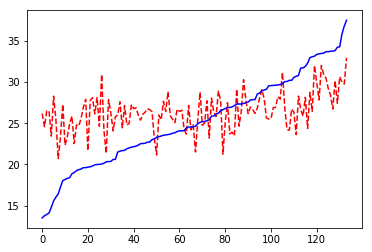

In [19]:
plt.figure()
plt.plot(y_all_sorted[predicted_name].values,'r--',y_all_sorted[LABEL].values,'b')

In [20]:
regressor.get_params()

{'params': {'dnn_activation_fn': <function tensorflow.python.ops.gen_nn_ops.elu>,
  'dnn_dropout': 0.2,
  'dnn_feature_columns': [_NumericColumn(key='bodyAngleZ', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearKneesAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearAnkle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='frontHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='rearHipsAngle', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
   _NumericColumn(key='swingFtHeight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),

In [21]:
ev_train = regressor.evaluate(
     input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))#,metrics=validation_metrics)
print('MSE train (tensorflow): {0:f}'.format(ev_train['loss']))
train_predictions = regressor.predict_scores(input_fn=get_input_fn(X_train_all_wts, y_train, LABEL, num_epochs=1, shuffle=False))
y_predicted_train = list(itertools.islice(train_predictions,y_train[LABEL].size))

Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer supported.
INFO:tensorflow:Starting evaluation at 2017-10-18-22:24:12


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 986, in emit
    msg = self.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 836, in format
    return fmt.format(record)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 573, in format
    record.message = record.getMessage()
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\logging\__init__.py", line 336, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _ru

INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2202
INFO:tensorflow:Finished evaluation at 2017-10-18-22:24:13
INFO:tensorflow:Saving dict for global step 2202: global_step = 2202, loss = 22.3864
MSE train (tensorflow): 22.386356
INFO:tensorflow:Restoring parameters from /DNNNew/DNNAngry/wideAndDeep/angry_wideNoFFPDeep_ConfidenceELU2Layer100_100UnitsDropout02EarlyStopLR001\model.ckpt-2202


In [22]:
# Score with sklearn.
score_sklearn_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train)
print('MSE train (sklearn): {0:f}'.format(score_sklearn_train))
r2_score_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train)
print('R2 train (sklearn): {0:f}'.format(r2_score_train))
# Score with sklearn.
score_sklearn_wtd_train = metrics.mean_squared_error(y_train[LABEL].values,y_predicted_train,sample_weight=X_train_all_wts[WT_COL].values)
print('MSE WTD train (sklearn): {0:f}'.format(score_sklearn_wtd_train))
r2_score_wtd_train = metrics.r2_score(y_train[LABEL].values, y_predicted_train, sample_weight=X_train_all_wts[WT_COL].values)
print('R2 WTD train (sklearn): {0:f}'.format(r2_score_wtd_train))

MSE train (sklearn): 25.910951
R2 train (sklearn): 0.147036
MSE WTD train (sklearn): 22.757269
R2 WTD train (sklearn): 0.264026


Populating the interactive namespace from numpy and matplotlib


C:\Users\t_desar\AppData\Local\Continuum\Anaconda3\envs\tensorflow\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


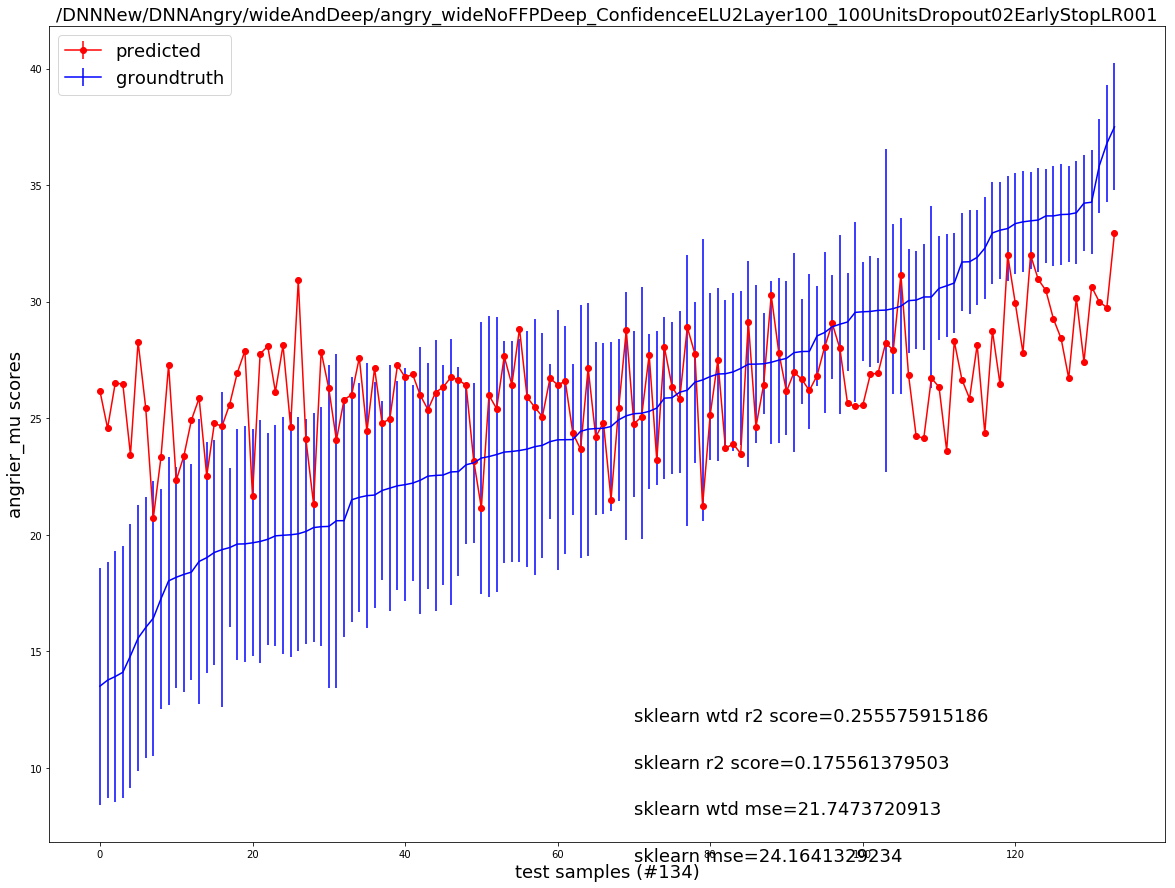

In [23]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted[predicted_name].size, 1)
plt.errorbar(x,y_all_sorted[predicted_name].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted[LABEL].values,yerr=y_all_sorted[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('test samples (#'+str(y_test[LABEL].size)+')',fontsize=18)
plt.ylabel(LABEL +' scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn), fontsize=18)
plt.show()
fig_name = model_dir_name + "/testPrediction.pdf"
ax.savefig(fig_name) 

In [24]:
predicted_name_train ="predicted_"+LABEL+"_train"
y_hat_train = pd.DataFrame(y_predicted_train, columns=[predicted_name_train], index=y_train[LABEL].index) 
y_all_train = pd.concat([y_hat_train, y_train[LABEL], y_train[EMOCONFIDENCE_INV[LABEL_ID]], y_train["gif_id"]], axis=1) #gif id is only for debugging
y_all_sorted_train = y_all_train.sort_values(EMOSCORES[LABEL_ID],ascending=[True])

Populating the interactive namespace from numpy and matplotlib


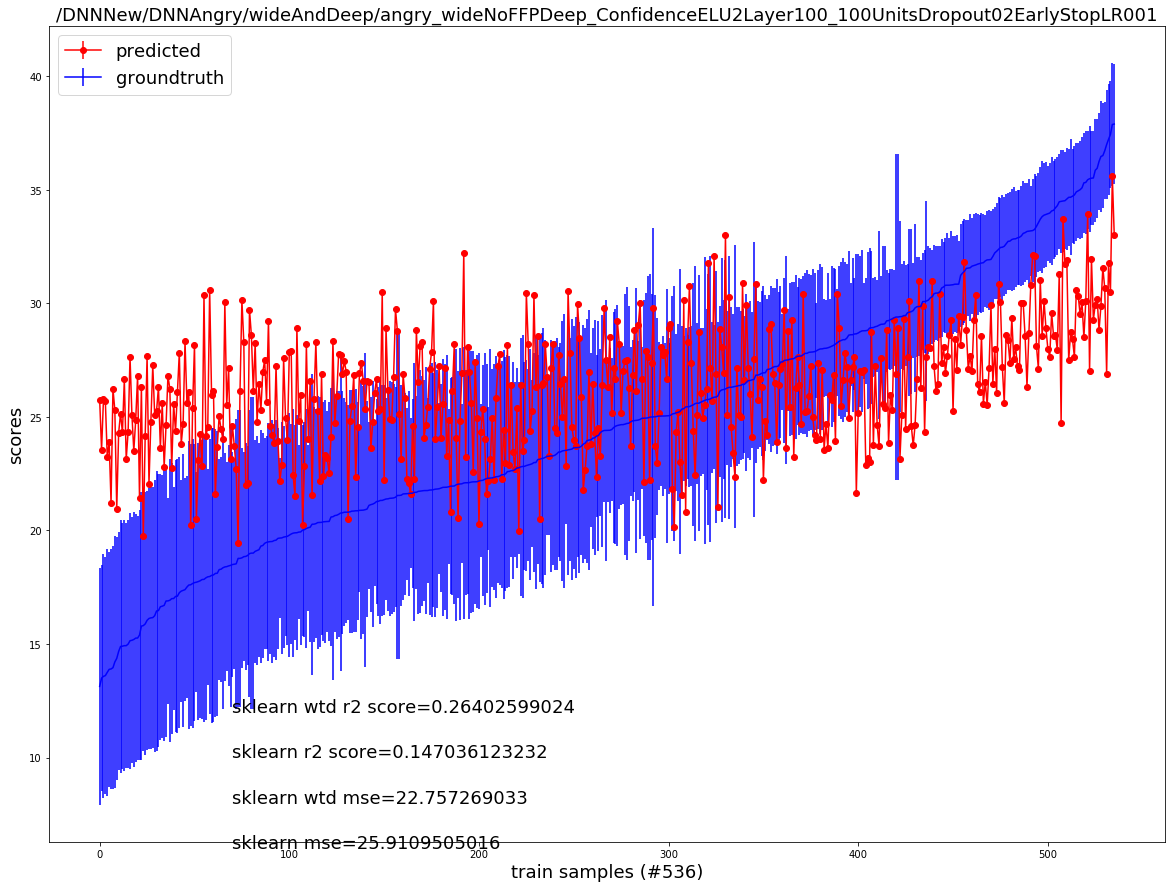

In [25]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 15)
ax =plt.figure()
x = np.arange(0, y_all_sorted_train[predicted_name_train].size, 1)
plt.errorbar(x,y_all_sorted_train[predicted_name_train].values,yerr=0,fmt='r-o',label="predicted")
plt.errorbar(x,y_all_sorted_train[LABEL].values,yerr=y_all_sorted_train[EMOCONFIDENCE_INV[LABEL_ID]],fmt='b',label="groundtruth")
plt.title(model_dir_name,fontsize=18)
plt.xlabel('train samples (#'+str(y_train[LABEL].size)+')',fontsize=18)
plt.ylabel('scores',fontsize=18)
pylab.legend(loc='upper left', fontsize=18)
plt.text(70,12, 'sklearn wtd r2 score='+str(r2_score_wtd_train), fontsize=18)
plt.text(70,10, 'sklearn r2 score='+str(r2_score_train), fontsize=18)
plt.text(70,8, 'sklearn wtd mse='+str(score_sklearn_wtd_train), fontsize=18)
plt.text(70,6, 'sklearn mse='+str(score_sklearn_train), fontsize=18)
plt.show()
fig_name = model_dir_name + "/trainPrediction.pdf"
ax.savefig(fig_name) 